In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
from PIL import Image
import numpy as np
import time
import os
import copy
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## Computer Excersice 1

#### (a)

In [ ]:
batch_size = 32

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.SVHN(root='./data', download=True, transform=transform, split = 'train')
testset = torchvision.datasets.SVHN(root='./data', download=True, transform=transform, split = 'test')

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

#### (b)
In this section we take a subset of the train and test data porpotional to 10,000 train examples for faster computation

In [ ]:
size_train = 73257
size_test = 26032
subset_size = 10000
train_size = 8000
val_size =2000
test_size = int((subset_size/size_train)*size_test )
trainset_subset = torch.utils.data.Subset(trainset,np.random.choice(size_train ,10000) )
testset_subset = torch.utils.data.Subset(testset,np.random.choice(size_test ,test_size) )
train, val = torch.utils.data.random_split(trainset_subset, [int(0.8*subset_size), subset_size - int(0.8*subset_size) ])

#### (c)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

val_loader = torch.utils.data.DataLoader(dataset=val,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

test_loader = torch.utils.data.DataLoader(dataset=testset_subset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

#### (d)

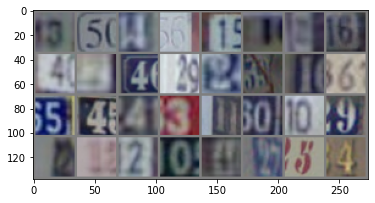

In [ ]:

# for plotting images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))



## Computer Excersice 2
## 3.1

In [ ]:
input = torch.randn(20,3,32 ,32) 
input_size = 3072

def MLP(hidden1 = 128, hidden2 = 64 ):
  model_mlp = nn.Sequential(nn.Linear(input_size, 128),
                        nn.ReLU(),
                        nn.Linear(128, 64),
                        nn.ReLU(),
                        nn.Linear(64, 10))
  return model_mlp


## 3.2

In [ ]:
class CNN(nn.Module):
    def __init__(self, k_size = 3):
        super().__init__()
        image_shape = 32
        self.conv1 = nn.Conv2d(3, 10, kernel_size = k_size, stride = 1, padding = 1)
        conv1_shape = int((image_shape+2-(k_size-1)-1)+1)

        self.pool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 0)
        pool_shape = int((conv1_shape-3)/2+1)

        self.conv2 = nn.Conv2d(10, 20, kernel_size = k_size, stride = 1, padding = 1)
        conv2_shape = int((pool_shape+2-(k_size-1)-1)+1)
        pool_shape = int((conv2_shape-3)/2+1)


        self.fc1 = nn.Linear(20 * pool_shape**2 , 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch       
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# quick test
model_cnn= CNN().to(device)
input = torch.randn(20,3,32, 32).to(device)
model_cnn(input).shape



torch.Size([20, 10])

In [ ]:

# a function that returns the one hot encoded labels given an output of softmax 
def get_label(data):
    max_idx = torch.argmax(data, 1, keepdim=True).to(device)
    one_hot = torch.FloatTensor(data.shape).to(device)
    one_hot.zero_()
    output = one_hot.scatter_(1, max_idx, 1)
    return output

# model trainer for the MLP and CNN together
def trainer(model_mlp, model_cnn, print_  = False, lr = 0.001):
  epochs  = 30
  criterion1 = nn.CrossEntropyLoss()
  criterion2 = nn.CrossEntropyLoss()

  # optimizers
  optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=lr)
  optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=lr)

  # lists for documenting the loss and accuracy
  train_loss_mlp =[]
  train_loss_cnn =[]
  val_loss_mlp =[]
  val_loss_cnn =[]
  train_acc_mlp = []
  train_acc_cnn = []
  val_acc_mlp = []
  val_acc_cnn = []

  for epoch in range(epochs):  # loop over the dataset multiple times
      running_loss_mlp = 0.0
      running_loss_cnn= 0.0
      cnt = 0
      acc_mlp = 0
      acc_cnn = 0
      for i, data in enumerate(train_loader, 0):

          cnt = cnt + 1
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs  = inputs.to(device)
          labels  = labels.to(device)

          # zero the parameter gradients
          optimizer_mlp.zero_grad()
          optimizer_cnn.zero_grad()

          outputs_mlp = model_mlp(inputs.view(len(inputs), -1))
          outputs_cnn = model_cnn(inputs)

          pred_mlp = get_label(outputs_mlp)
          pred_cnn = get_label(outputs_cnn)

          classes = F.one_hot(labels,num_classes=10)
          acc_mlp += torch.sum((2*pred_mlp-classes)==1)
          acc_cnn += torch.sum((2*pred_cnn-classes)==1)
        
          loss_mlp  = criterion1(outputs_mlp, labels)
          loss_cnn  = criterion2(outputs_cnn, labels)
          
          loss_mlp.backward()
          loss_cnn.backward()
          
          optimizer_mlp.step()
          optimizer_cnn.step()
          
          running_loss_mlp += loss_mlp.item()
          running_loss_cnn += loss_cnn.item()

      train_acc_mlp.append(acc_mlp.item()/8000)
      train_acc_cnn.append(acc_cnn.item()/8000)
              
      train_loss_mlp.append(running_loss_mlp/cnt)
      train_loss_cnn.append(running_loss_cnn/cnt) 
      
      running_loss_mlp = 0.0
      running_loss_cnn= 0.0
      acc_mlp = 0
      acc_cnn = 0

      # compute the valdiation acc and loss, loop in batches
      with torch.no_grad():    
          for j, data in enumerate(val_loader, 0):
            
              inputs, labels = data
              inputs  = inputs.to(device)
              labels  = labels.to(device)
             
              outputs_mlp = model_mlp(inputs.view(len(inputs), -1))
              outputs_cnn = model_cnn(inputs)

              pred_mlp = get_label(outputs_mlp)
              pred_cnn = get_label(outputs_cnn)

              classes = F.one_hot(labels,num_classes=10)
              acc_mlp += torch.sum((2*pred_mlp-classes)==1)
              acc_cnn += torch.sum((2*pred_cnn-classes)==1)
              
              running_loss_mlp += loss_mlp.item()
              running_loss_cnn += loss_cnn.item()
             
              loss_mlp  = criterion1(outputs_mlp, labels)
              loss_cnn  = criterion2(outputs_cnn, labels)
              
      val_loss_mlp.append(running_loss_mlp/cnt) 
      val_loss_cnn.append(running_loss_cnn/cnt)

      val_acc_mlp.append(acc_mlp.item()/2000)
      val_acc_cnn.append(acc_cnn.item()/2000) 

      # print epoch info
      if print==True:
          print("epoch {}, train loss mlp {}, val loss mlp {}, train loss cnn {}, val loss cnn {}".format(epoch,
                                                                                                    train_loss_mlp[-1],
                                                                                                    val_loss_mlp[-1],
                                                                                                    train_loss_cnn[-1],
                                                                                                     val_loss_cnn[-1]))      
  # the output
  out =   (model_mlp, model_cnn, train_loss_mlp, val_loss_mlp, train_loss_cnn
           , val_loss_cnn,train_acc_mlp, train_acc_cnn, val_acc_mlp, val_acc_cnn)                                                                                                                                                                                           
  return out 

print('Finished Training')


Finished Training


### Computer Exercise 3 - 4 - 5

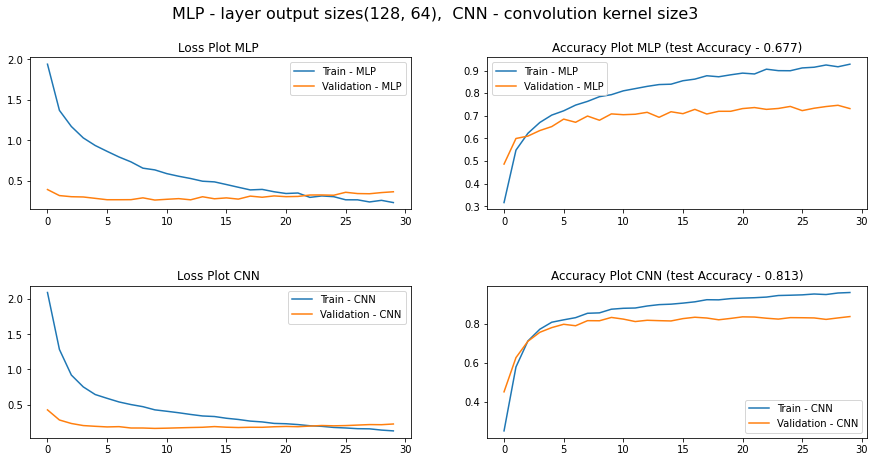

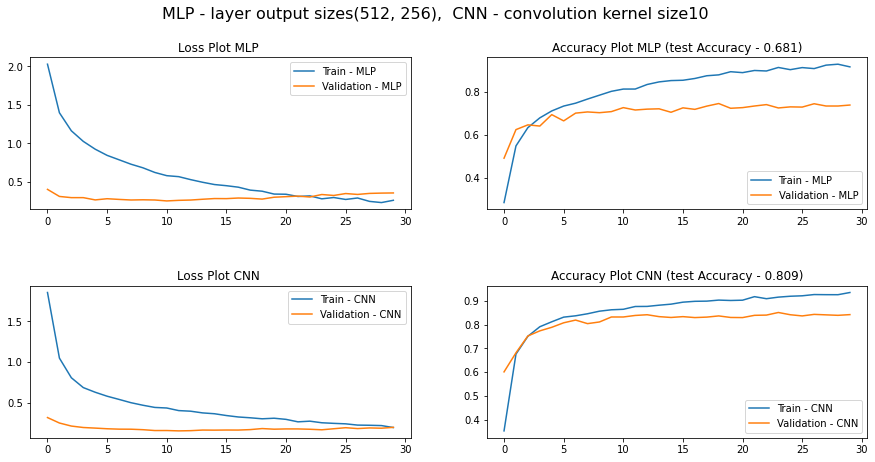

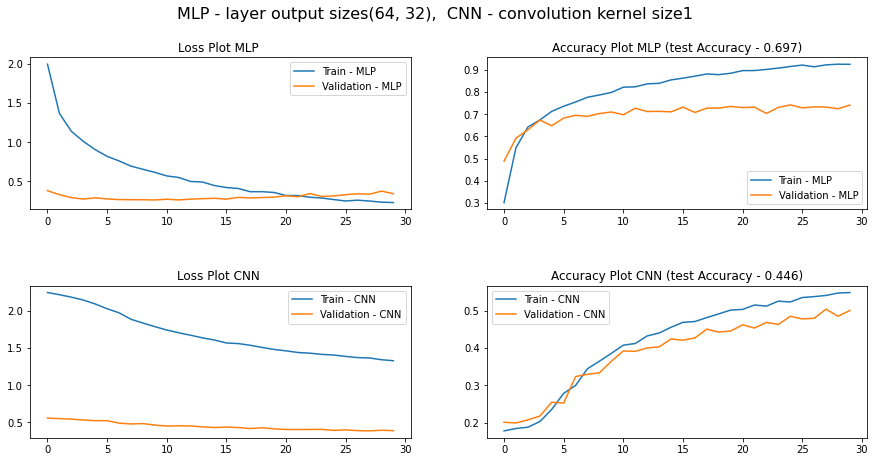

In [ ]:

# this function computes the required tasks in 3,4 and 5 computer exercises
def run_ce4(lr = 0.001 ) :

  # the different network combinations
  nets1 = {"MLP":(128,64),'CNN':3}
  nets2  = {"MLP":(512,256),'CNN':10}
  nets3 ={"MLP":(64,32),'CNN':1}
  loader = test_loader

  cnt = 0
  for params in [nets1,nets2, nets3]:
    model_mlp = MLP(params['MLP']).to(device)
    model_cnn = CNN(params['CNN']).to(device)
    output = trainer(model_mlp, model_cnn,lr = lr) 
    model_mlp, model_cnn, train_loss_mlp, val_loss_mlp, train_loss_cnn, val_loss_cnn,_,_,_,_ = output
    _, _,_, _, _, _, train_acc_mlp, train_acc_cnn, val_acc_mlp, val_acc_cnn = output

    acc_mlp=0
    acc_cnn=0
    
    # compute the accuracy
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.no_grad():
              pred_mlp = get_label(model_mlp(inputs.view(len(inputs), -1)))
              pred_cnn = get_label(model_cnn(inputs))

        classes = F.one_hot(labels,num_classes=10)
        acc_mlp += torch.sum((2*pred_mlp-classes)==1)/test_size
        acc_cnn += torch.sum((2*pred_cnn-classes)==1)/test_size


    # plot the results + accuracy
    cnt +=1
    fig, ax = plt.subplots(2, 2,figsize = (15,7))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('MLP - layer output sizes' + str(params['MLP']) + ',  CNN - convolution kernel size' + str(params['CNN']), fontsize=16)
    ax[0,0].plot(train_loss_mlp) 
    ax[0,0].plot(val_loss_mlp) 
    ax[0,0].legend(["Train - MLP","Validation - MLP"])
    ax[0,0].title.set_text('Loss Plot MLP ' )

    ax[0,1].plot(train_acc_mlp)
    ax[0,1].plot(val_acc_mlp) 
    ax[0,1].legend(["Train - MLP","Validation - MLP"])
    ax[0,1].title.set_text('Accuracy Plot MLP (test Accuracy - ' + str(np.round(acc_mlp.item(),3)) + ")")

    ax[1,0].plot(train_loss_cnn) 
    ax[1,0].plot(val_loss_cnn) 
    ax[1,0].legend(["Train - CNN","Validation - CNN"])
    ax[1,0].title.set_text('Loss Plot CNN ' )

    ax[1,1].plot(train_acc_cnn) 
    ax[1,1].plot(val_acc_cnn)
    ax[1,1].legend(["Train - CNN","Validation - CNN"])
    ax[1,1].title.set_text('Accuracy Plot CNN (test Accuracy - ' + str(np.round(acc_cnn.item(),3))+ ")")
    plt.show()

# run the model
run_ce4()

In [ ]:
# trainer for the transfer learning model

def train_model(model, criterion, optimizer, num_epochs=30, print_ = False):
    since = time.time()

    train_loss =[]
    val_loss =[]
    train_acc = []
    val_acc= []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    dataloaders = {'train': train_loader,'val':val_loader,'test': test_loader}
    dataset_sizes = {'train': 8000,'val':2000,'test': 14000}
    for epoch in range(num_epochs):
        if print_==True:
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)
        cnt = 0
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
              

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                cnt +=1

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if print_ == True:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())

            else:
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())

    
    if print_ == True:
        print()
        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_loss,val_loss,train_acc,val_acc

## Convt - Fine Tuning

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

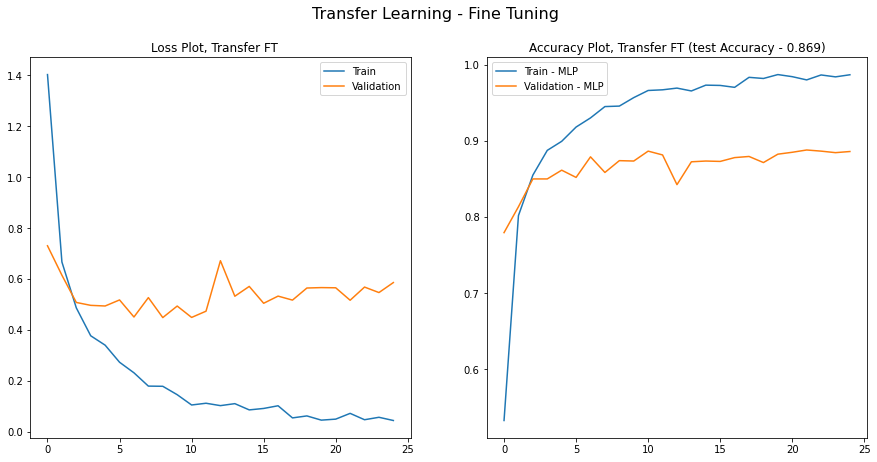

In [ ]:

# this function return the required results for computer exercise 6, transfer learning with fine tuning. 
def run_ce6(lr= 0.001) :
  model_ft = torchvision.models.resnet18(pretrained=True)

  # Parameters of newly constructed modules have requires_grad=True by default
  num_ftrs = model_ft.fc.in_features
  model_ft.fc = nn.Linear(num_ftrs, 10)

  model_ft  = model_ft.to(device)

  criterion = nn.CrossEntropyLoss()

  # Observe that only parameters of final layer are being optimized as
  # opposed to before.
  optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr)

  output = train_model(model_ft, criterion, optimizer_ft, num_epochs=25)
  model,train_loss,val_loss,train_acc,val_acc = output

  loader = test_loader

  acc=0

  for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      with torch.no_grad():
            pred = get_label(model(inputs))

      classes = F.one_hot(labels,num_classes=10)
      acc += torch.sum((2*pred-classes)==1)/test_size

  fig, ax = plt.subplots(1, 2,figsize = (15,7))
  fig.suptitle('Transfer Learning - Fine Tuning', fontsize=16)
  fig.subplots_adjust(hspace=0.5)
  ax[0].plot(train_loss) 
  ax[0].plot(val_loss) 
  ax[0].legend(["Train","Validation"])
  ax[0].title.set_text('Loss Plot, Transfer FT   ' )

  ax[1].plot(train_acc) 
  ax[1].plot(val_acc) 
  ax[1].legend(["Train - MLP","Validation - MLP"])
  ax[1].title.set_text('Accuracy Plot, Transfer FT (test Accuracy - ' + str(np.round(acc.item(),3)) + ")")


  plt.show()
  
run_ce6()

## Problem 5

### Experiment lr = 0.1

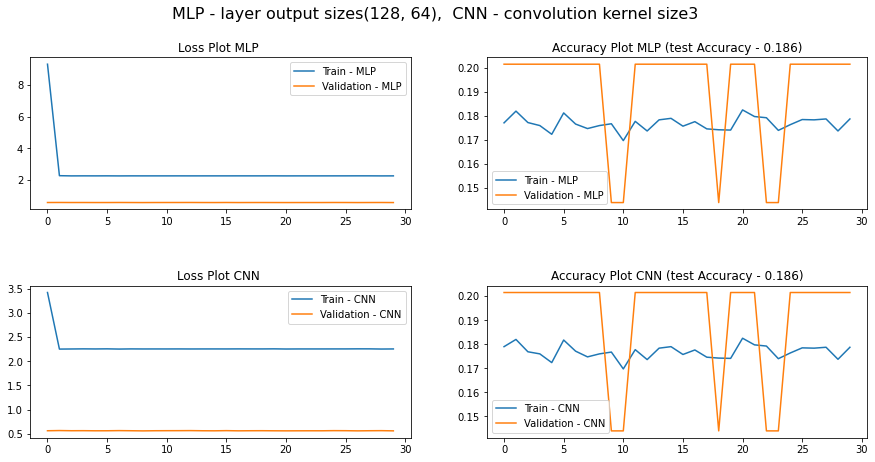

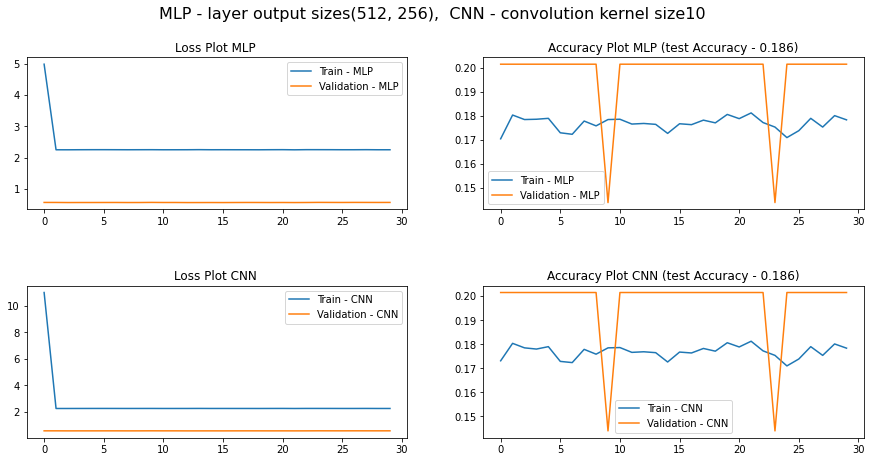

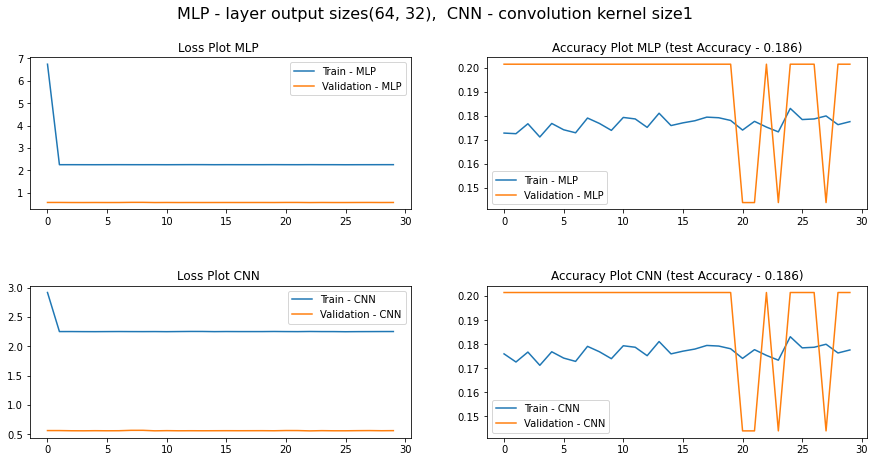

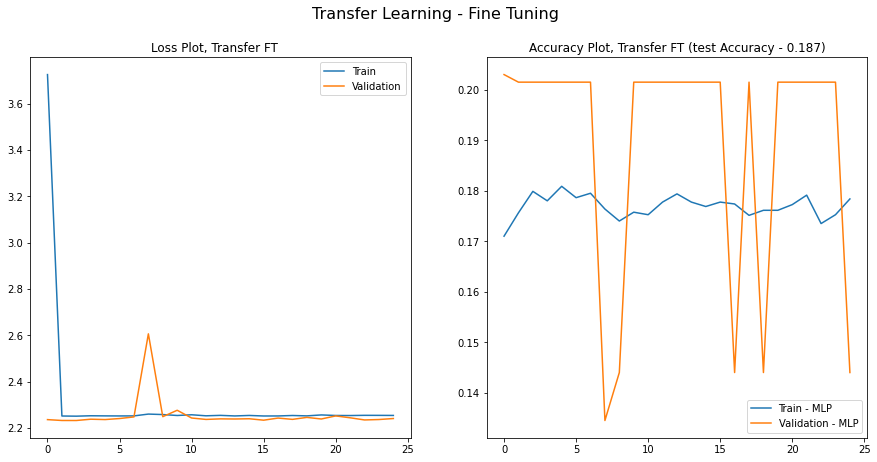

In [ ]:

run_ce4(0.1)
run_ce6(0.1)

## Experiment lr = 0.0001

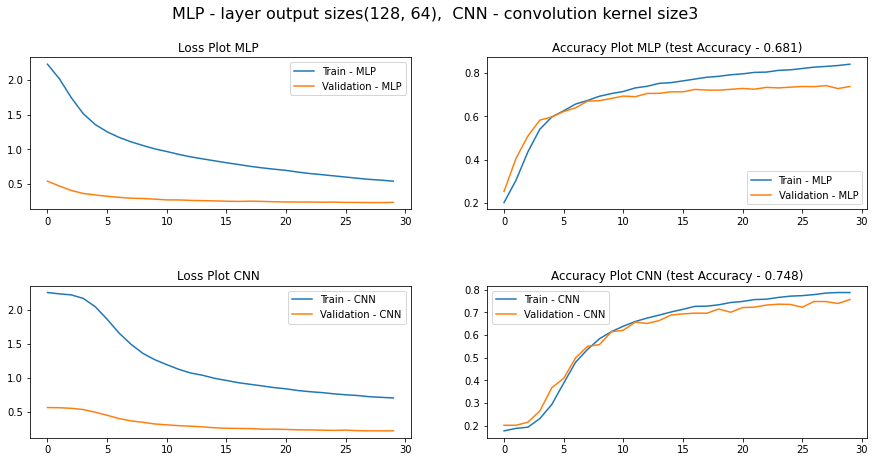

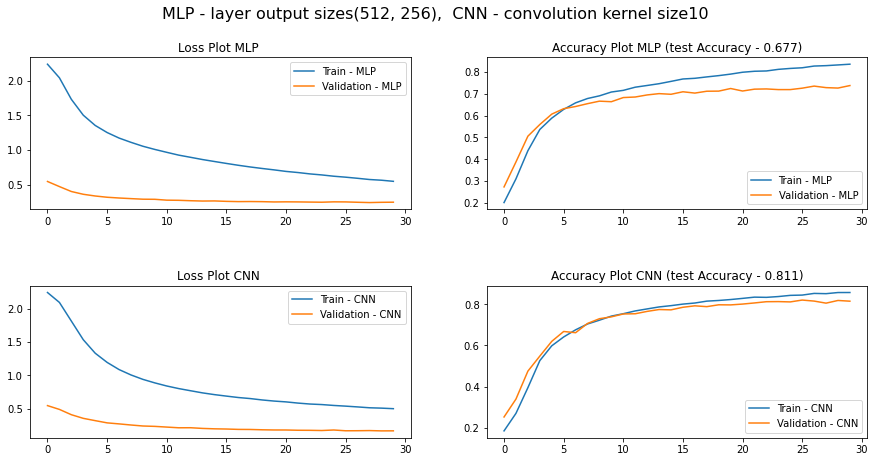

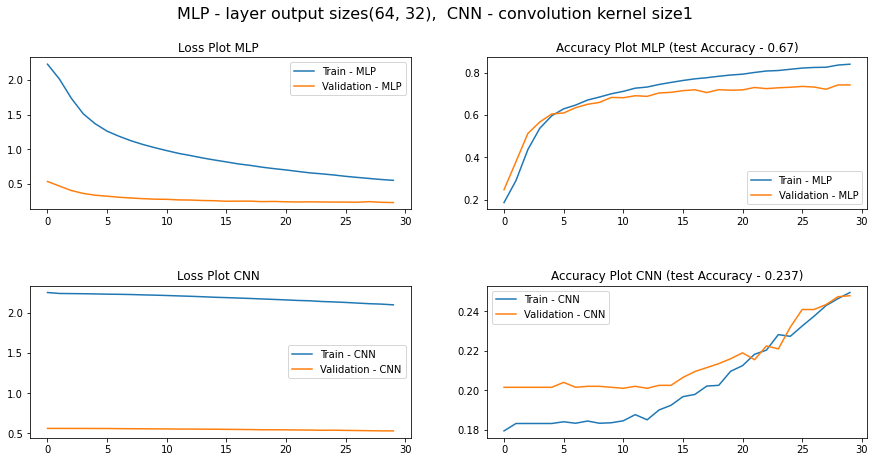

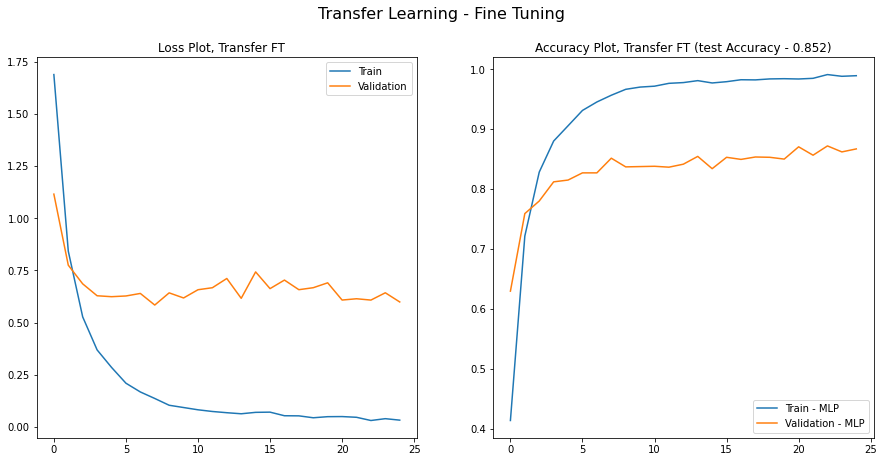

In [ ]:
run_ce4(0.0001)
run_ce6(0.0001)